In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import RegressorChain
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import periodogram
import itertools
import time
from xgboost import XGBRegressor

In [109]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
holidays = pd.read_csv('data/holidays_events.csv')
oil = pd.read_csv('data/oil.csv')
stores = pd.read_csv('data/stores.csv')
transactions = pd.read_csv('data/transactions.csv')

In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


<Axes: xlabel='date'>

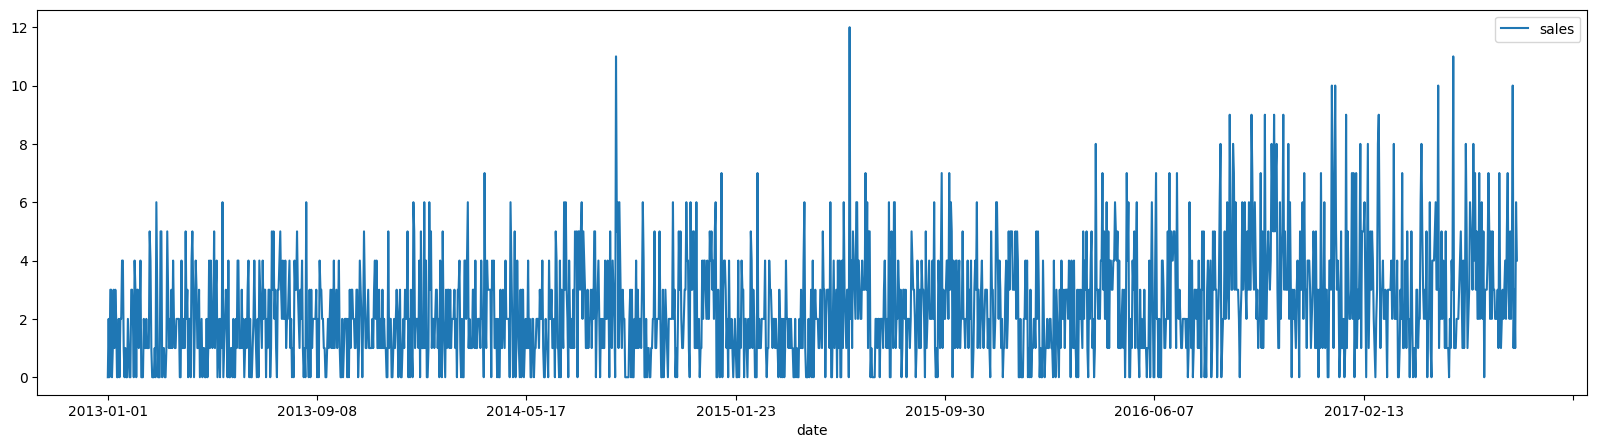

In [5]:
train[(train["store_nbr"] == 1) & (train["family"] == "BEAUTY")][["date", "sales"]].plot(x="date", y="sales", figsize=(20, 5))

In [6]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [3]:
oil = oil.fillna(0)

In [4]:
train = pd.merge(train, oil, on="date", how="left")

In [9]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,0.0


In [10]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
stores.type.value_counts()

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

In [12]:
stores.cluster.value_counts()

cluster
3     7
6     6
10    6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: count, dtype: int64

In [5]:
stores = pd.get_dummies(stores, columns=["type", "cluster"], drop_first=True, dtype=int)
stores.head()

,store_nbr,city,state,type_B,type_C,type_D,type_E,cluster_2,cluster_3,cluster_4,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,1,Quito,Pichincha,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,Quito,Pichincha,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,Quito,Pichincha,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,Quito,Pichincha,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,5,Santo Domingo,Santo Domingo de los Tsachilas,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
stores = stores[["store_nbr", "type_B", "type_C", "type_D", "type_E", "cluster_2", "cluster_3", "cluster_4", "cluster_5", "cluster_6", "cluster_7", "cluster_8", "cluster_9",
                 "cluster_10", "cluster_11", "cluster_12", "cluster_13", "cluster_14", "cluster_15", "cluster_16", "cluster_17"]]

In [7]:
train = pd.merge(train, stores, on="store_nbr", how="left")
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_B,type_C,type_D,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [16]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
holidays = holidays[holidays["transferred"] == False]
holidays = holidays[holidays["locale"].isin(["National", "Regional"])]
holidays = holidays[["date", "description"]]
holidays = pd.get_dummies(holidays, columns=["description"], prefix="", prefix_sep="", dtype=int)

In [9]:
train = pd.merge(train, holidays, on="date", how="left")

In [10]:
train = train.drop("id", axis=1)

In [11]:
train["date"] = pd.to_datetime(train["date"])

In [12]:
train = train.set_index(["date"])

In [22]:
train.head()

,store_nbr,family,sales,onpromotion,dcoilwtico,type_B,type_C,type_D,type_E,cluster_2,...,Terremoto Manabi+5,Terremoto Manabi+6,Terremoto Manabi+7,Terremoto Manabi+8,Terremoto Manabi+9,Traslado Batalla de Pichincha,Traslado Independencia de Guayaquil,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BABY CARE,0.0,0,0.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BEAUTY,0.0,0,0.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BEVERAGES,0.0,0,0.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BOOKS,0.0,0,0.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
average_sales = (
    train["sales"]
    .groupby('date').mean()
    .squeeze()
)

<Axes: xlabel='day'>

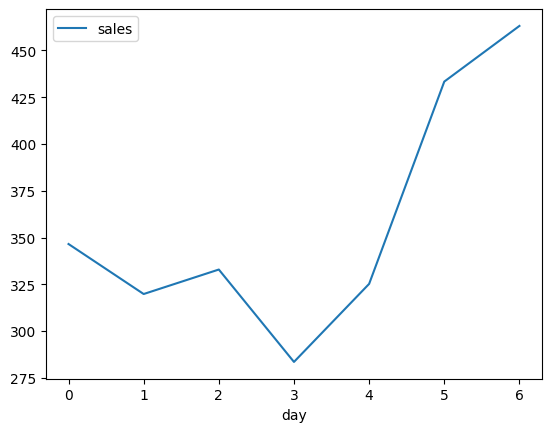

In [24]:
# Plot seasonal sales inside a week
average_sales = average_sales.to_frame()
average_sales["day"] = average_sales.index.dayofweek
average_sales_weekday = average_sales.groupby("day").mean()
average_sales_weekday.plot()

In [25]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

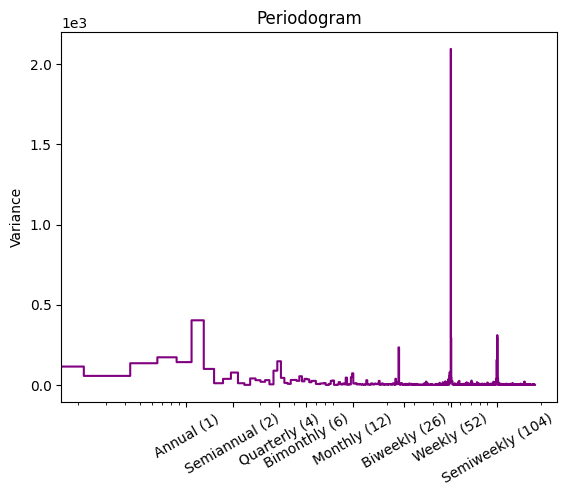

In [26]:
plot_periodogram(average_sales["sales"])

In [31]:
y = train[["store_nbr", "family", "sales"]].copy()
y = y.reset_index()
y


,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.000
1,2013-01-01,1,BABY CARE,0.000
2,2013-01-01,1,BEAUTY,0.000
3,2013-01-01,1,BEVERAGES,0.000
4,2013-01-01,1,BOOKS,0.000
...,...,...,...,...
3009793,2017-08-15,9,POULTRY,438.133
3009794,2017-08-15,9,PREPARED FOODS,154.553
3009795,2017-08-15,9,PRODUCE,2419.729
3009796,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000


In [32]:
y["store_nbr"] = y["store_nbr"].astype("category")
y["family"] = y["family"].astype("category")
y["date"] = y["date"].dt.to_period("D")
#y = y.set_index(['store_nbr', 'family', 'date']).sort_index()
y

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.000
1,2013-01-01,1,BABY CARE,0.000
2,2013-01-01,1,BEAUTY,0.000
3,2013-01-01,1,BEVERAGES,0.000
4,2013-01-01,1,BOOKS,0.000
...,...,...,...,...
3009793,2017-08-15,9,POULTRY,438.133
3009794,2017-08-15,9,PREPARED FOODS,154.553
3009795,2017-08-15,9,PRODUCE,2419.729
3009796,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000


In [33]:
y = y.pivot_table(index="date", columns=["store_nbr", "family"], values="sales", fill_value=0)

C:\Users\ivan.trujillo_blueta\AppData\Local\Temp\ipykernel_22552\829371325.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  y = y.pivot_table(index="date", columns=["store_nbr", "family"], values="sales", fill_value=0)


In [26]:
y

store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0      0.00000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0    470.65200   
2013-01-03        3.0       0.0    0.0     919.0   0.0    310.65500   
2013-01-04        3.0       0.0    3.0     953.0   0.0    198.36600   
2013-01-05        5.0       0.0    3.0    1160.0   0.0    301.05700   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

store_nbr                                        ...        54             \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES      MEATS   
date                                             ...                        
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771000   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257000   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223000   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431000   
...                ...      ...    ...      ...  ...       ...        ...   
2017-08-11         4.0    341.0  343.0   64.302  ...       0.0  50.756000   
2017-08-12         3.0    351.0  526.0   99.488  ...       1.0  53.079002   
2017-08-13         1.0    169.0  266.0   47.770  ...       3.0  67.435000   
2017-08-14         4.0    571.0  699.0  154.578  ...       1.0  64.224000   
2017-08-15        21.0    703.0  602.0  116.402  ...       2.0  57.842000   

store_nbr                                                                 \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS    POULTRY   
date                                                                       
2013-01-01           0.0          0.0                     0.0   0.000000   
2013-01-02         228.0          0.0                     0.0  15.514000   
2013-01-03         156.0          0.0                     0.0   4.313000   
2013-01-04         146.0          0.0                     0.0  26.743000   
2013-01-05         205.0          0.0                     0.0  31.118000   
...                  ...          ...                     ...        ...   
2017-08-11         155.0          0.0                     0.0  80.759000   
2017-08-12         169.0          0.0                     4.0  91.671000   
2017-08-13         244.0          0.0                     2.0  79.062996   
2017-08-14         200.0          0.0                     1.0  56.155000   
2017-08-15         169.0          0.0                     2.0  59.619000   

store_nbr                                                              
family     PREPARED FOODS  PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                   
2013-01-01            0.0    0.000                        0.0     0.0  
2013-01-02           61.0    0.000                        0.0     3.0  
2013-01-03            1.0    0.000                        0.0     2.0  
2013-01-04           38.0    0.000                        0.0     2.0  
2013-01-05           32.0    0.000                        0.0     1.0  
...                   ...      ...                        ...     ...  
2017-08-11           54.0  546.250                        0.0     0.0  
2017-08-12           81.0  696.920                        0.0     1.0  
2017-08-13           91.0  877.304                        0.0     2.0

In [17]:
oil["date"] = pd.to_datetime(oil["date"]).dt.to_period("D")

In [76]:
fourier = CalendarFourier(freq="ME", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)
X["holiday"] = y.index.isin(holidays.index)
X = X.merge(oil, left_index=True, right_on="date", how="left")
X = X.set_index(y.index).drop("date", axis=1)
X = X.fillna(0)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [77]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)",NewYear,holiday,dcoilwtico
date,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True,False,0.00
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False,False,93.14
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False,False,92.97
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False,False,93.12
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False,False,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.0,0.0,0.0,0.0,0.0,1.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653,False,False,48.81
2017-08-12,1.0,1681.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,False,False,0.00
2017-08-13,1.0,1682.0,1.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139,False,False,0.00


In [78]:
y_pred

store_nbr           1                                                          \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2013-01-01  -1.393507       0.0 -0.896865  -756.296952 -0.284730   -82.797546   
2013-01-02   2.412411       0.0  1.880299   883.030831 -0.158067   296.869247   
2013-01-03   2.118333       0.0  1.898238   815.938851 -0.218325   267.380857   
2013-01-04   2.502464       0.0  2.001304   921.284554 -0.095101   279.093204   
2013-01-05   1.558463       0.0  1.272062   563.120347 -0.243373   197.744528   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   4.989451       0.0  3.288842  2495.306821  0.436895   450.847498   
2017-08-12   4.378074       0.0  2.936923  2386.980784  0.395022   396.573424   
2017-08-13   4.413973       0.0  2.831567  2258.704882  0.435097   382.196547   
2017-08-14   4.464125       0.0  3.307982  2386.116429  0.460578   409.961319   
2017-08-15   4.779969       0.0  3.555227  2510.301132  0.580226   423.481502   

store_nbr                                                   ...        54  \
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2013-01-01   -9.091472 -100.042249 -183.279339  -21.728506  ... -0.555258   
2013-01-02   -1.009585  728.916769  469.728426  117.722955  ... -0.157271   
2013-01-03   -1.870647  667.751347  433.441808  108.234827  ... -0.228294   
2013-01-04   -0.325139  714.933329  462.310906  110.927106  ... -0.466968   
2013-01-05   -3.897430  451.460432  341.772223   83.796328  ... -0.355260   
...                ...         ...         ...         ...  ...       ...   
2017-08-11   20.609864  766.879001  866.811645  151.207255  ...  1.137082   
2017-08-12   18.423770  610.959976  805.450059  134.435477  ...  1.415961   
2017-08-13   16.263058  590.789850  752.218085  130.131040  ...  1.415302   
2017-08-14   16.509248  683.955348  799.541909  140.981736  ...  1.195006   
2017-08-15   17.260047  736.583663  836.306816  146.928353  ...  0.990901   

store_nbr                                                                 \
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2013-01-01  -2.188414    -11.013158    -0.125559               -1.995819   
2013-01-02  43.653605    158.474225    -0.031937               -0.120788   
2013-01-03  46.513924    172.580601     0.012064               -0.231568   
2013-01-04  42.040238    160.645676    -0.042023               -0.338495   
2013-01-05  61.031903    242.110562     0.045791               -0.031803   
...               ...           ...          ...                     ...   
2017-08-11  53.792649    165.295973     0.224675                3.966033   
2017-08-12  57.849007    217.995687     0.193671                4.731375   
2017-08-13  59.856684    230.428296     0.238200                4.933880   
2017-08-14  55.724150    194.954546     0.273520                4.371008   
2017-08-15  53.734509    198.014491     0.195224                4.186004   

store_nbr                                                                    \
family        POULTRY PREPARED FOODS     PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                          
2013-01-01  -5.755717     -16.310303 -357.893810                  -1.136624   
2013-01-02  38.236237      38.799262  -43.127521                  -0.195470   
2013-01-03  40.120384      41.469384  -37.093638                  -0.470789   
2013-01-04  33.338776      37.497660  -34.221935                  -0.915048   
2013-01-05  49.457734      47.215824   17.913309                  -0.780739   
...               ...            ...         ...                        ...   
2017-08-11

In [34]:
y.loc(axis=1)[(1, "AUTOMOTIVE")]

date
2013-01-01    0.0
2013-01-02    2.0
2013-01-03    3.0
2013-01-04    3.0
2013-01-05    5.0
             ... 
2017-08-11    1.0
2017-08-12    6.0
2017-08-13    1.0
2017-08-14    1.0
2017-08-15    4.0
Freq: D, Name: (1, AUTOMOTIVE), Length: 1684, dtype: float64

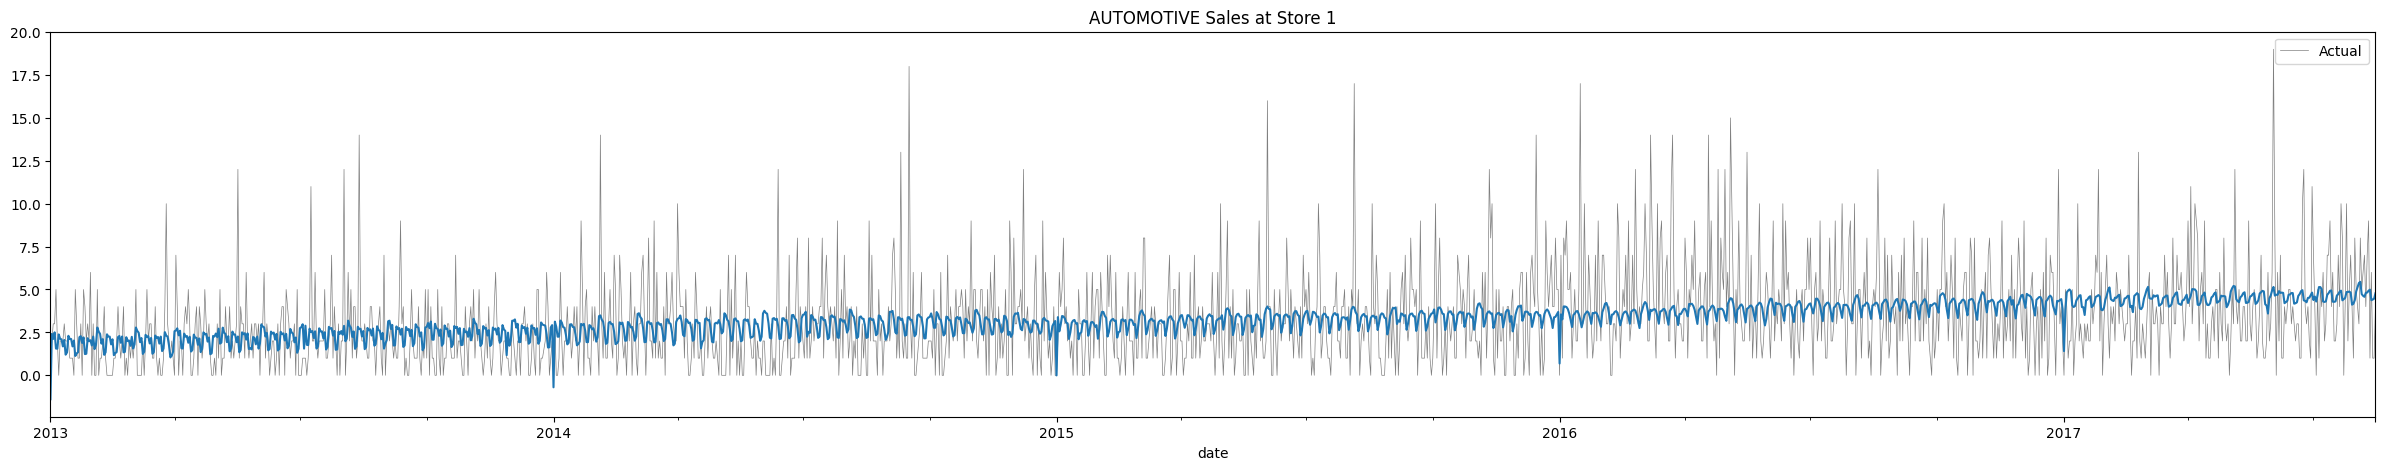

In [79]:
STORE_NBR = 1  # 1 - 54
FAMILY = 'AUTOMOTIVE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)[(STORE_NBR, FAMILY)].plot(figsize=(30, 5), title=f'{FAMILY} Sales at Store {STORE_NBR}', legend=True, label='Actual', color='black', alpha=0.5, linewidth=0.5)
ax = y_pred.loc(axis=1)[(STORE_NBR, FAMILY)].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [80]:
y_pred = y_pred.applymap(lambda x: 0 if x < 0 else x)

C:\Users\ivan.trujillo_blueta\AppData\Local\Temp\ipykernel_1988\3455201706.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  y_pred = y_pred.applymap(lambda x: 0 if x < 0 else x)


In [81]:
root_mean_squared_log_error(y.loc(axis=1)[(STORE_NBR, FAMILY)], y_pred.loc(axis=1)[(STORE_NBR, FAMILY)])

0.6613439203537523

In [82]:
root_mean_squared_log_error(y, y_pred)

0.8636938404958088

SARIMAX

In [36]:
STORE_NBR = 1  # 1 - 54
FAMILY = 'AUTOMOTIVE'

print("Estamos trabajando con la serie {}\n".format(str(STORE_NBR) + " / " + FAMILY))
resultado_analisis = adfuller(y.loc(axis=1)[(STORE_NBR, FAMILY)])

valor_estadistico_adf = resultado_analisis[0]
p_valor = resultado_analisis[1]

print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))

print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
print("p-valor: {}\n".format(p_valor))

Estamos trabajando con la serie 1 / AUTOMOTIVE

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -4.0786235381524785

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.0010503940884976403



In [44]:
y.loc(axis=1)[(STORE_NBR, FAMILY)].shift(1).fillna(0)

date
2013-01-01    0.0
2013-01-02    0.0
2013-01-03    2.0
2013-01-04    3.0
2013-01-05    3.0
             ... 
2017-08-11    9.0
2017-08-12    1.0
2017-08-13    6.0
2017-08-14    1.0
2017-08-15    1.0
Freq: D, Name: (1, AUTOMOTIVE), Length: 1684, dtype: float64

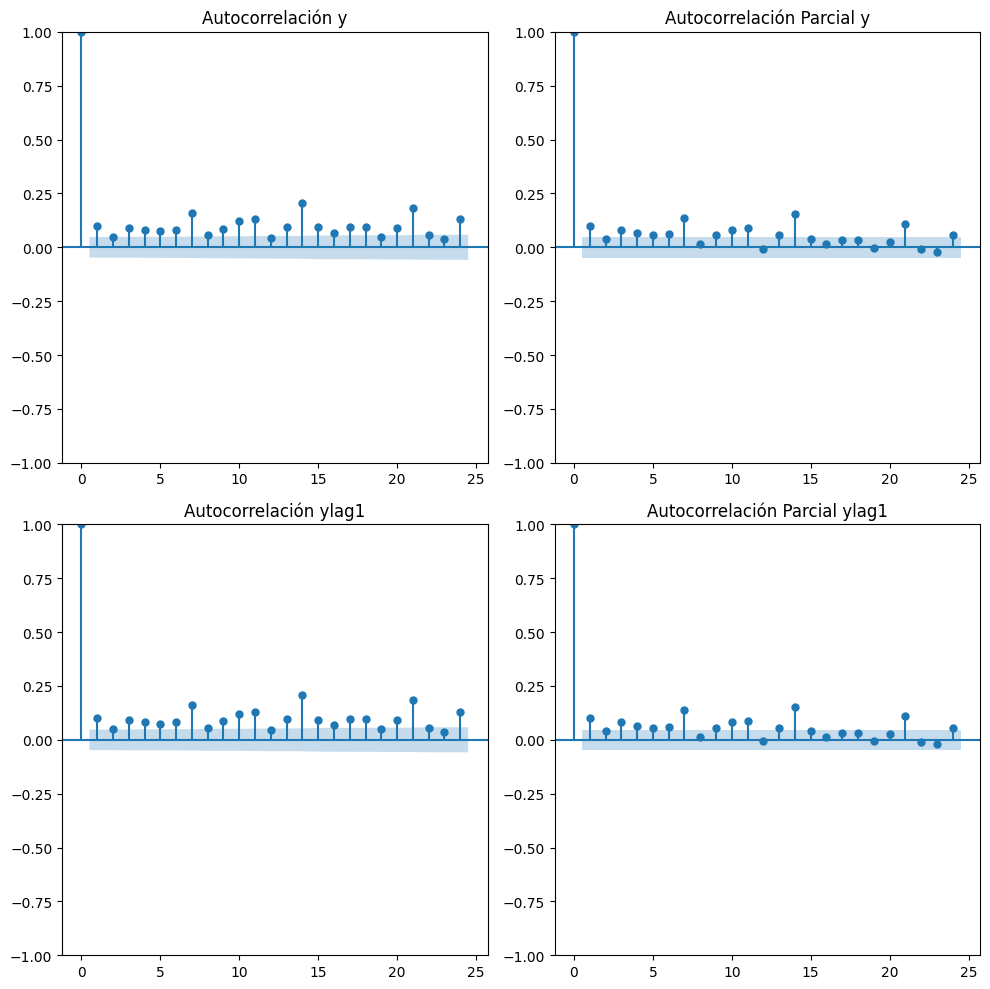

In [50]:
LAGS = 24

fig = plt.figure(figsize = (10, 10))

((ax1, ax2), (ax3, ax4)) = fig.subplots(2, 2)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module
plot_acf(y.loc(axis=1)[(STORE_NBR, FAMILY)], ax = ax1, lags = LAGS, title = "Autocorrelación y")
plot_pacf(y.loc(axis=1)[(STORE_NBR, FAMILY)], ax = ax2, lags = LAGS, title = "Autocorrelación Parcial y")
plot_acf(y.loc(axis=1)[(STORE_NBR, FAMILY)].shift(1).fillna(0), ax = ax3, lags = LAGS, title = "Autocorrelación ylag1")
plot_pacf(y.loc(axis=1)[(STORE_NBR, FAMILY)].shift(1).fillna(0), ax = ax4, lags = LAGS, title = "Autocorrelación Parcial ylag1")

fig.tight_layout()

In [52]:
# ARIMA o SARIMAX (ARIMA con estacionalidad y un componente exógeno)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 1, 0) x (0, 0, 0, 12)


In [54]:
length = y.loc(axis=1)[(STORE_NBR, FAMILY)].shape[0]
y_train = y.loc(axis=1)[(STORE_NBR, FAMILY)].iloc[:int(length * 0.8)]
y_test = y.loc(axis=1)[(STORE_NBR, FAMILY)].iloc[int(length * 0.8):]

In [56]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = SARIMAX(y_train,
                        order=param,
                        seasonal_order=param_seasonal,
                        enforce_stationarity = False,
                        enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        # alguna combinación de parámetros en SARIMAX, no son válidos
        # y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("The search has taken {} minutes".format((et - st)/60))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7617.52392947398
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7276.060210939896
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:7020.708948851452
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:7322.228215901467
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6371.415967391853
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:6319.4403909820585
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:8761.091018759456
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:7254.431476665397
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:6340.8989399432085
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:7017.772997055824
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6405.333145905634
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:6356.8418157097885
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6783.075297324632
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6373.398639485853
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:6315.137563093052
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:7785.32124258516
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:6784.832280926474
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:6353.2120743353935
ARIMA(0,

c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:6341.441204045017
ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:6589.174985969556
ARIMA(0, 0, 2)x(2, 1, 1, 12)12 - AIC:6333.7123065768865
ARIMA(0, 0, 2)x(2, 1, 2, 12)12 - AIC:6311.563704936592
ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:7343.515704737058
ARIMA(0, 0, 2)x(2, 2, 1, 12)12 - AIC:6598.840716334695


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(2, 2, 2, 12)12 - AIC:6338.7006019735
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:7300.351665546366
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:7238.678107911259
ARIMA(0, 1, 0)x(0, 0, 2, 12)12 - AIC:7176.757057840903
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:8273.185089944935
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:7226.308430481426
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:7160.233032449669
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:9720.591873119987
ARIMA(0, 1, 0)x(0, 2, 1, 12)12 - AIC:8189.221578805819
ARIMA(0, 1, 0)x(0, 2, 2, 12)12 - AIC:7210.476977858087
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:7241.916314186687
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:7235.605634767674
ARIMA(0, 1, 0)x(1, 0, 2, 12)12 - AIC:7177.3282645636
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:7685.036755161199
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:7226.029183326126
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:7152.301608324539


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 2, 0, 12)12 - AIC:8666.213002300885
ARIMA(0, 1, 0)x(1, 2, 1, 12)12 - AIC:7679.8525930393425


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 2, 2, 12)12 - AIC:7212.428300198167
ARIMA(0, 1, 0)x(2, 0, 0, 12)12 - AIC:7180.210746753917
ARIMA(0, 1, 0)x(2, 0, 1, 12)12 - AIC:7181.760615445397
ARIMA(0, 1, 0)x(2, 0, 2, 12)12 - AIC:7179.219675869803
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:7502.977696653223
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:7171.355174669048
ARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:7154.300617007491
ARIMA(0, 1, 0)x(2, 2, 0, 12)12 - AIC:8233.420167300941
ARIMA(0, 1, 0)x(2, 2, 1, 12)12 - AIC:7504.302890455682
ARIMA(0, 1, 0)x(2, 2, 2, 12)12 - AIC:7215.594212546159
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:6392.634615709597
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:6342.951681613809
ARIMA(0, 1, 1)x(0, 0, 2, 12)12 - AIC:6290.785954133655
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:7321.055699715775
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:6331.800159502309
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:6278.958164159601
ARIMA(0, 1, 1)x(0, 2, 0, 12)12 - AIC:8757.903643459855
ARIMA(0, 1, 1)x(0, 2, 1, 12)12 - AIC:7257.669633532754
ARIMA(0, 1

c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(2, 2, 2, 12)12 - AIC:6339.321795171847
ARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:6390.951570748701
ARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC:6341.25914720155
ARIMA(0, 1, 2)x(0, 0, 2, 12)12 - AIC:6288.671850473331
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:7317.02115105116
ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:6330.009730180864
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:6276.7989886475625
ARIMA(0, 1, 2)x(0, 2, 0, 12)12 - AIC:8751.131977135568
ARIMA(0, 1, 2)x(0, 2, 1, 12)12 - AIC:7253.448774915526
ARIMA(0, 1, 2)x(0, 2, 2, 12)12 - AIC:6332.8303355439475
ARIMA(0, 1, 2)x(1, 0, 0, 12)12 - AIC:6352.4692536390485
ARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:6339.739373736785
ARIMA(0, 1, 2)x(1, 0, 2, 12)12 - AIC:6290.205453264242
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:6789.979448655089
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:6334.923444501644
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:6271.897732008687
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:7791.189367310919
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:6787.7425575370735


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:6334.825439567692
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:6302.4415706023965
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:6304.352410631029
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:6292.099752445274
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:6595.8277623096255
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:6289.930878491456
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:6273.8977919675235
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:7349.280791661703
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:6612.520852275429


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:6337.5306550376135
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:8746.813426980898
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:8674.794369861353
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:8601.702008632461
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:9687.882365341782
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:8646.9884388
ARIMA(0, 2, 0)x(0, 1, 2, 12)12 - AIC:8568.920799994296
ARIMA(0, 2, 0)x(0, 2, 0, 12)12 - AIC:11112.950504896533
ARIMA(0, 2, 0)x(0, 2, 1, 12)12 - AIC:9578.363963149382
ARIMA(0, 2, 0)x(0, 2, 2, 12)12 - AIC:8606.01846185429
ARIMA(0, 2, 0)x(1, 0, 0, 12)12 - AIC:8679.680320187359
ARIMA(0, 2, 0)x(1, 0, 1, 12)12 - AIC:8673.615946146409
ARIMA(0, 2, 0)x(1, 0, 2, 12)12 - AIC:8602.219836778746
ARIMA(0, 2, 0)x(1, 1, 0, 12)12 - AIC:9113.617443361036
ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:8648.82551323327
ARIMA(0, 2, 0)x(1, 1, 2, 12)12 - AIC:8563.144380616377


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 0)x(1, 2, 0, 12)12 - AIC:10071.479308121769
ARIMA(0, 2, 0)x(1, 2, 1, 12)12 - AIC:9094.411035387064
ARIMA(0, 2, 0)x(1, 2, 2, 12)12 - AIC:8607.916929263525
ARIMA(0, 2, 0)x(2, 0, 0, 12)12 - AIC:8606.409081588588
ARIMA(0, 2, 0)x(2, 0, 1, 12)12 - AIC:8607.913419756362
ARIMA(0, 2, 0)x(2, 0, 2, 12)12 - AIC:8604.348843009226
ARIMA(0, 2, 0)x(2, 1, 0, 12)12 - AIC:8919.786145420181
ARIMA(0, 2, 0)x(2, 1, 1, 12)12 - AIC:8575.707768980235
ARIMA(0, 2, 0)x(2, 1, 2, 12)12 - AIC:8565.143060107848
ARIMA(0, 2, 0)x(2, 2, 0, 12)12 - AIC:9632.46130457487
ARIMA(0, 2, 0)x(2, 2, 1, 12)12 - AIC:8907.985669034304
ARIMA(0, 2, 0)x(2, 2, 2, 12)12 - AIC:8609.356091379876
ARIMA(0, 2, 1)x(0, 0, 0, 12)12 - AIC:7299.7539423340695
ARIMA(0, 2, 1)x(0, 0, 1, 12)12 - AIC:7238.021076556806
ARIMA(0, 2, 1)x(0, 0, 2, 12)12 - AIC:7175.7250155787115
ARIMA(0, 2, 1)x(0, 1, 0, 12)12 - AIC:8270.9160063126
ARIMA(0, 2, 1)x(0, 1, 1, 12)12 - AIC:7230.230940465259
ARIMA(0, 2, 1)x(0, 1, 2, 12)12 - AIC:7164.087389570492
ARIMA(0, 2

c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:7246.680636405426
ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:7234.059350023025
ARIMA(0, 2, 1)x(1, 0, 2, 12)12 - AIC:7175.670523769306
ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:7689.409157917113
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:7231.397883148176
ARIMA(0, 2, 1)x(1, 1, 2, 12)12 - AIC:7155.349653796119
ARIMA(0, 2, 1)x(1, 2, 0, 12)12 - AIC:8669.776698486501
ARIMA(0, 2, 1)x(1, 2, 1, 12)12 - AIC:7684.479966302213
ARIMA(0, 2, 1)x(1, 2, 2, 12)12 - AIC:7219.546076108183
ARIMA(0, 2, 1)x(2, 0, 0, 12)12 - AIC:7184.954312509851
ARIMA(0, 2, 1)x(2, 0, 1, 12)12 - AIC:7186.165752845645
ARIMA(0, 2, 1)x(2, 0, 2, 12)12 - AIC:7177.66899092502
ARIMA(0, 2, 1)x(2, 1, 0, 12)12 - AIC:7507.429824209561


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1)x(2, 1, 1, 12)12 - AIC:7174.1058980890875
ARIMA(0, 2, 1)x(2, 1, 2, 12)12 - AIC:7157.349623626578
ARIMA(0, 2, 1)x(2, 2, 0, 12)12 - AIC:8237.24877637762
ARIMA(0, 2, 1)x(2, 2, 1, 12)12 - AIC:7515.611674782764
ARIMA(0, 2, 1)x(2, 2, 2, 12)12 - AIC:7225.799143838886
ARIMA(0, 2, 2)x(0, 0, 0, 12)12 - AIC:6398.281053175538
ARIMA(0, 2, 2)x(0, 0, 1, 12)12 - AIC:6348.601922549482
ARIMA(0, 2, 2)x(0, 0, 2, 12)12 - AIC:6301.793288353172
ARIMA(0, 2, 2)x(0, 1, 0, 12)12 - AIC:7328.376120309513
ARIMA(0, 2, 2)x(0, 1, 1, 12)12 - AIC:6342.5604655030065


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(0, 1, 2, 12)12 - AIC:6299.675529815561
ARIMA(0, 2, 2)x(0, 2, 0, 12)12 - AIC:8761.62865620453
ARIMA(0, 2, 2)x(0, 2, 1, 12)12 - AIC:7262.203027263234


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(0, 2, 2, 12)12 - AIC:6349.037287143043
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:6366.331074228548


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:6347.93085949044
ARIMA(0, 2, 2)x(1, 0, 2, 12)12 - AIC:6305.097068912073
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:6803.413486897157


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:6363.3693552461145


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(1, 1, 2, 12)12 - AIC:6282.998663070375
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:7802.9215309043275
ARIMA(0, 2, 2)x(1, 2, 1, 12)12 - AIC:6802.952448318485


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(1, 2, 2, 12)12 - AIC:6441.075594375899


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:6317.2920726516295
ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:6462.53204302045
ARIMA(0, 2, 2)x(2, 0, 2, 12)12 - AIC:6462.019320340084


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:6609.833650833193


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 1, 1, 12)12 - AIC:6305.629246728894


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 1, 2, 12)12 - AIC:6528.676794208646


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 2, 0, 12)12 - AIC:7363.413438799981


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 2, 1, 12)12 - AIC:6669.801695178571


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 2, 2, 12)12 - AIC:6684.968564936875
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:7009.733797687045
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:6949.843801305997
ARIMA(1, 0, 0)x(0, 0, 2, 12)12 - AIC:6827.5563291399885
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:7323.438439558978
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:6372.81272844211
ARIMA(1, 0, 0)x(0, 1, 2, 12)12 - AIC:6320.651376752915
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:8761.160331419553
ARIMA(1, 0, 0)x(0, 2, 1, 12)12 - AIC:7255.645454160253
ARIMA(1, 0, 0)x(0, 2, 2, 12)12 - AIC:6342.633109920813
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:6940.4022300223205
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:6407.127414048133
ARIMA(1, 0, 0)x(1, 0, 2, 12)12 - AIC:6358.5511798066345
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:6779.189357704398
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:6377.518297367742
ARIMA(1, 0, 0)x(1, 1, 2, 12)12 - AIC:6316.177533455777
ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:7780.295724906329
ARIMA(1, 0, 0)x(1, 2, 1, 12)12 - AIC:6786.792303626845
ARIMA(1,

c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(2, 2, 2, 12)12 - AIC:6346.682511228035
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:6398.003953481843
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:6348.513698663553
ARIMA(1, 0, 1)x(0, 0, 2, 12)12 - AIC:6296.491007351047
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:7276.7409274249085
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:6365.930520979287
ARIMA(1, 0, 1)x(0, 1, 2, 12)12 - AIC:6315.784174872055
ARIMA(1, 0, 1)x(0, 2, 0, 12)12 - AIC:8649.959299530581
ARIMA(1, 0, 1)x(0, 2, 1, 12)12 - AIC:7208.77222656012
ARIMA(1, 0, 1)x(0, 2, 2, 12)12 - AIC:6337.363378941858
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:6351.549122747874


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:6347.168437549595


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 2, 12)12 - AIC:6298.148669467825
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:6779.484769234083
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:6367.91376757384
ARIMA(1, 0, 1)x(1, 1, 2, 12)12 - AIC:6311.221848467709
ARIMA(1, 0, 1)x(1, 2, 0, 12)12 - AIC:7782.599215062421
ARIMA(1, 0, 1)x(1, 2, 1, 12)12 - AIC:6776.205814348175
ARIMA(1, 0, 1)x(1, 2, 2, 12)12 - AIC:6351.8823057588315
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:6301.460044517188


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC:6315.348892040099


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC:6310.683976986678
ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:6586.910527920943
ARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:6320.556572019649
ARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC:6313.221718926343
ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:7340.1254916654525
ARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:6596.008365672778


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:6344.793123561006
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:6396.252603218313
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:6346.7507043058085


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:6294.132189539744
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:7296.7895707232055
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:6364.184750701901
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:6313.8756999616035
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:8720.515091042998
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:7227.925297913935
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:6336.6823225994285
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:6353.5482367588775


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:6346.782785168216


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:6304.534714691239
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:6778.777026847805
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:6370.047858136086
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:6309.239411741389
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:7722.6304685847235
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:6775.977284991467
ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:6347.0936293599


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:6303.428145571303


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:6315.589209151732


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:6305.20777593596
ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:6586.647354864286
ARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:6322.50654018249
ARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:6311.23926083858
ARIMA(1, 0, 2)x(2, 2, 0, 12)12 - AIC:7339.256503594326
ARIMA(1, 0, 2)x(2, 2, 1, 12)12 - AIC:6595.7625953786255


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 2, 2, 12)12 - AIC:6341.164234145974
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:6963.890979676098
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:6899.489878650979
ARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:6836.24639404027
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:7970.840516013579
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:6895.653872721145
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:6828.64327555602
ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:9434.19550780071
ARIMA(1, 1, 0)x(0, 2, 1, 12)12 - AIC:7892.190858466383
ARIMA(1, 1, 0)x(0, 2, 2, 12)12 - AIC:6884.761096491047
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:6896.833217301786
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:6892.242388333166
ARIMA(1, 1, 0)x(1, 0, 2, 12)12 - AIC:6836.699762621324
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:7334.640178868998
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:6888.426596719145
ARIMA(1, 1, 0)x(1, 1, 2, 12)12 - AIC:6817.41105381336
ARIMA(1, 1, 0)x(1, 2, 0, 12)12 - AIC:8336.299293578219
ARIMA(1, 1, 0)x(1, 2, 1, 12)12 - AIC:7337.692479168254


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 2, 2, 12)12 - AIC:6886.345169276628
ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:6834.795610463876
ARIMA(1, 1, 0)x(2, 0, 1, 12)12 - AIC:6836.538220584598
ARIMA(1, 1, 0)x(2, 0, 2, 12)12 - AIC:6838.537447548235
ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:7153.001166329653
ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:6827.161974287096
ARIMA(1, 1, 0)x(2, 1, 2, 12)12 - AIC:6819.408874412986
ARIMA(1, 1, 0)x(2, 2, 0, 12)12 - AIC:7893.085251022212
ARIMA(1, 1, 0)x(2, 2, 1, 12)12 - AIC:7156.640369308348
ARIMA(1, 1, 0)x(2, 2, 2, 12)12 - AIC:6883.691763373103
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:6394.62615768789
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:6344.946105534766
ARIMA(1, 1, 1)x(0, 0, 2, 12)12 - AIC:6292.784308796233
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:7322.281961123466
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:6333.775688901752
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:6280.942555893325
ARIMA(1, 1, 1)x(0, 2, 0, 12)12 - AIC:8758.000454480092
ARIMA(1, 1, 1)x(0, 2, 1, 12)12 - AIC:7258.834027257344
ARIMA(1, 1,

c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(2, 2, 2, 12)12 - AIC:6346.775764493732
ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:6388.900234494655
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:6340.192765039049
ARIMA(1, 1, 2)x(0, 0, 2, 12)12 - AIC:6287.38284501935
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:7253.635289196945
ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:6332.038570580717
ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:6276.727025963941
ARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:8658.052706385555
ARIMA(1, 1, 2)x(0, 2, 1, 12)12 - AIC:7197.834183477506


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(0, 2, 2, 12)12 - AIC:6332.582125206083
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:6347.65286069092
ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:6338.281343783515
ARIMA(1, 1, 2)x(1, 0, 2, 12)12 - AIC:6289.141225956808
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:6786.821809804443
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:6333.992536482754


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:6271.856555274136
ARIMA(1, 1, 2)x(1, 2, 0, 12)12 - AIC:7725.1228436996
ARIMA(1, 1, 2)x(1, 2, 1, 12)12 - AIC:6761.751103953061


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(1, 2, 2, 12)12 - AIC:6344.6924746988425
ARIMA(1, 1, 2)x(2, 0, 0, 12)12 - AIC:6297.62769606347
ARIMA(1, 1, 2)x(2, 0, 1, 12)12 - AIC:6299.512145854126
ARIMA(1, 1, 2)x(2, 0, 2, 12)12 - AIC:6290.90171350124
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:6593.222191805259
ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:6285.434990118376


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(2, 1, 2, 12)12 - AIC:6275.596335554867
ARIMA(1, 1, 2)x(2, 2, 0, 12)12 - AIC:7300.047601851588
ARIMA(1, 1, 2)x(2, 2, 1, 12)12 - AIC:6591.981115415092


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(2, 2, 2, 12)12 - AIC:6337.646588792046
ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:8031.559007298623
ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:7955.494536573304
ARIMA(1, 2, 0)x(0, 0, 2, 12)12 - AIC:7874.907012333308
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:9042.537208111458
ARIMA(1, 2, 0)x(0, 1, 1, 12)12 - AIC:7946.624876287058
ARIMA(1, 2, 0)x(0, 1, 2, 12)12 - AIC:7867.041078614668
ARIMA(1, 2, 0)x(0, 2, 0, 12)12 - AIC:10510.840288010866
ARIMA(1, 2, 0)x(0, 2, 1, 12)12 - AIC:8944.510470282607
ARIMA(1, 2, 0)x(0, 2, 2, 12)12 - AIC:7917.253596784472
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:7951.646437593601
ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:7941.645662795681
ARIMA(1, 2, 0)x(1, 0, 2, 12)12 - AIC:7871.720201841825
ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:8350.48553990014
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:7935.713334404253
ARIMA(1, 2, 0)x(1, 1, 2, 12)12 - AIC:7849.047594744125
ARIMA(1, 2, 0)x(1, 2, 0, 12)12 - AIC:9328.502903172852
ARIMA(1, 2, 0)x(1, 2, 1, 12)12 - AIC:8344.136951992043
ARIMA(1, 2

c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(0, 2, 2, 12)12 - AIC:6892.250339448011
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:6901.831279472393
ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:6891.631317076263
ARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC:6835.2567140266565
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:7339.21584572154
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:6901.9012980331745
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:6820.691359114548
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:8339.943942095828
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:7343.141549362593
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:6894.544351695277
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:6839.739261155624
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:6841.208104406703
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:6837.256571332871
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:7157.3507866869095
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:6836.328211753986
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:6822.691275376908
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:7897.055672069591
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:7167.852620486712


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:6895.100057734087
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:6400.27564558431
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:6351.155577175556
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:6299.526903931666
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:7329.678763738245
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:6344.508825022595
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:6291.422072937681


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:8761.831674663725


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 2, 1, 12)12 - AIC:7263.55913232063


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 2, 2, 12)12 - AIC:6356.012691753853
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:6362.69938976063
ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:6350.968385174383
ARIMA(1, 2, 2)x(1, 0, 2, 12)12 - AIC:6309.697636973589
ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:6799.426160279189


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:6347.7103180045615
ARIMA(1, 2, 2)x(1, 1, 2, 12)12 - AIC:6285.266129289998
ARIMA(1, 2, 2)x(1, 2, 0, 12)12 - AIC:7797.795260182669
ARIMA(1, 2, 2)x(1, 2, 1, 12)12 - AIC:6808.335509708724
ARIMA(1, 2, 2)x(1, 2, 2, 12)12 - AIC:7693.640239208635
ARIMA(1, 2, 2)x(2, 0, 0, 12)12 - AIC:6310.873870023288
ARIMA(1, 2, 2)x(2, 0, 1, 12)12 - AIC:6315.3691543320865


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 0, 2, 12)12 - AIC:6303.337536832039
ARIMA(1, 2, 2)x(2, 1, 0, 12)12 - AIC:6614.675234189626


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 1, 1, 12)12 - AIC:6304.31035400933


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 1, 2, 12)12 - AIC:6287.7187337247615
ARIMA(1, 2, 2)x(2, 2, 0, 12)12 - AIC:7356.528221502252


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 2, 1, 12)12 - AIC:6732.958945676504


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 2, 2, 12)12 - AIC:6644.822258222979
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:6840.856678486013
ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:6794.350009409064
ARIMA(2, 0, 0)x(0, 0, 2, 12)12 - AIC:6709.034277127182
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:7300.1501709940685
ARIMA(2, 0, 0)x(0, 1, 1, 12)12 - AIC:6373.951747060457
ARIMA(2, 0, 0)x(0, 1, 2, 12)12 - AIC:6321.701411113889
ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:8723.598280419988


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(0, 2, 1, 12)12 - AIC:7237.059079305083
ARIMA(2, 0, 0)x(0, 2, 2, 12)12 - AIC:6343.742306417558
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:6789.875681844167
ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:6402.805434232549
ARIMA(2, 0, 0)x(1, 0, 2, 12)12 - AIC:6358.745832889932
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:6774.952100019729
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:6371.254351411824
ARIMA(2, 0, 0)x(1, 1, 2, 12)12 - AIC:6317.920631718276
ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:7773.842675673613
ARIMA(2, 0, 0)x(1, 2, 1, 12)12 - AIC:6781.496638051089
ARIMA(2, 0, 0)x(1, 2, 2, 12)12 - AIC:6355.316826238513
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:6669.505549339155
ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:6353.384500160006


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(2, 0, 2, 12)12 - AIC:6345.103023506917
ARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:6580.79090121538
ARIMA(2, 0, 0)x(2, 1, 1, 12)12 - AIC:6318.246645524678
ARIMA(2, 0, 0)x(2, 1, 2, 12)12 - AIC:6315.473278245984
ARIMA(2, 0, 0)x(2, 2, 0, 12)12 - AIC:7333.875885703936
ARIMA(2, 0, 0)x(2, 2, 1, 12)12 - AIC:6588.974769982645


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(2, 2, 2, 12)12 - AIC:6342.687614711053
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:6439.16598585987
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:6350.513580774801
ARIMA(2, 0, 1)x(0, 0, 2, 12)12 - AIC:6335.377684446115
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:7301.643871527051
ARIMA(2, 0, 1)x(0, 1, 1, 12)12 - AIC:6367.841887681067
ARIMA(2, 0, 1)x(0, 1, 2, 12)12 - AIC:6317.732135602565
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:8725.575235119246
ARIMA(2, 0, 1)x(0, 2, 1, 12)12 - AIC:7232.941943698808
ARIMA(2, 0, 1)x(0, 2, 2, 12)12 - AIC:6340.390536747875
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:6349.7985427254625


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:6365.140291457222


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 0, 2, 12)12 - AIC:6314.046511935636
ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:6773.938365920387
ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:6374.401674989008
ARIMA(2, 0, 1)x(1, 1, 2, 12)12 - AIC:6313.221768162918
ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:7769.721319548906
ARIMA(2, 0, 1)x(1, 2, 1, 12)12 - AIC:6780.495952434017


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 2, 2, 12)12 - AIC:6352.155491901303
ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:6298.166051169954


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:6310.622114301255


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 0, 2, 12)12 - AIC:6312.666873219745
ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:6582.309049524781
ARIMA(2, 0, 1)x(2, 1, 1, 12)12 - AIC:6318.501774055661
ARIMA(2, 0, 1)x(2, 1, 2, 12)12 - AIC:6315.222000830543
ARIMA(2, 0, 1)x(2, 2, 0, 12)12 - AIC:7334.2095263758065
ARIMA(2, 0, 1)x(2, 2, 1, 12)12 - AIC:6590.491848590524


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 2, 2, 12)12 - AIC:6344.671890470714
ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:6394.365601120796
ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:6345.602825653461


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 0, 2, 12)12 - AIC:6292.671820138954
ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:7298.732824402454


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 1, 1, 12)12 - AIC:6313.933343197716
ARIMA(2, 0, 2)x(0, 1, 2, 12)12 - AIC:6315.618360974404
ARIMA(2, 0, 2)x(0, 2, 0, 12)12 - AIC:8570.7216150858
ARIMA(2, 0, 2)x(0, 2, 1, 12)12 - AIC:7229.8577183039415
ARIMA(2, 0, 2)x(0, 2, 2, 12)12 - AIC:6338.746876996498
ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:6348.639903297591
ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:6343.7196337490695


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 0, 2, 12)12 - AIC:6294.466092571737


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:6752.939724646215
ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:6372.0401553562715
ARIMA(2, 0, 2)x(1, 1, 2, 12)12 - AIC:6311.155244303925
ARIMA(2, 0, 2)x(1, 2, 0, 12)12 - AIC:7664.921246161239
ARIMA(2, 0, 2)x(1, 2, 1, 12)12 - AIC:6772.263407783388


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 2, 2, 12)12 - AIC:6349.2355894358425
ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:6298.652158119704


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:6300.817659336479


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 0, 2, 12)12 - AIC:6296.314529398009
ARIMA(2, 0, 2)x(2, 1, 0, 12)12 - AIC:6584.293366644423
ARIMA(2, 0, 2)x(2, 1, 1, 12)12 - AIC:6320.23722526999
ARIMA(2, 0, 2)x(2, 1, 2, 12)12 - AIC:6313.157377123656


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 2, 0, 12)12 - AIC:7305.028662579382
ARIMA(2, 0, 2)x(2, 2, 1, 12)12 - AIC:6592.477266048628


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 2, 2, 12)12 - AIC:6343.312104951904
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:6783.857372291751
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:6730.602248626936
ARIMA(2, 1, 0)x(0, 0, 2, 12)12 - AIC:6676.725103044309
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:7753.06451290356
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:6720.788346721278
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:6659.468180197108
ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:9181.273579761615
ARIMA(2, 1, 0)x(0, 2, 1, 12)12 - AIC:7682.590551505455
ARIMA(2, 1, 0)x(0, 2, 2, 12)12 - AIC:6713.758498750921
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:6725.561302018674
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:6726.322285070433
ARIMA(2, 1, 0)x(1, 0, 2, 12)12 - AIC:6678.653203318721
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:7200.357502048129
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:6715.247155433789
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:6657.464945373878
ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:8210.330267398716
ARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC:7203.419824580985
ARIMA(2, 1,

c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(2, 2, 2, 12)12 - AIC:6340.803043134426
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:6389.569826332547
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:6340.864537725217
ARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:6294.596297788381
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:7246.2297679028325
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:6330.40804584501
ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:6277.3048914306055
ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:8639.330714597396
ARIMA(2, 1, 2)x(0, 2, 1, 12)12 - AIC:7190.216938643968


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(0, 2, 2, 12)12 - AIC:6332.835745995892
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:6344.062847624124
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:6339.29080418899
ARIMA(2, 1, 2)x(1, 0, 2, 12)12 - AIC:6290.251160108781
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:6747.45142343752
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:6330.913979035138
ARIMA(2, 1, 2)x(1, 1, 2, 12)12 - AIC:6272.796408550861
ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:7718.2097012676695
ARIMA(2, 1, 2)x(1, 2, 1, 12)12 - AIC:6787.3127969273955


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 2, 2, 12)12 - AIC:6344.7818132828215
ARIMA(2, 1, 2)x(2, 0, 0, 12)12 - AIC:6293.614013942901
ARIMA(2, 1, 2)x(2, 0, 1, 12)12 - AIC:6295.525640250471
ARIMA(2, 1, 2)x(2, 0, 2, 12)12 - AIC:6292.011474159564
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:6564.183333808127
ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:6281.773662002032


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 1, 2, 12)12 - AIC:6273.174700046551
ARIMA(2, 1, 2)x(2, 2, 0, 12)12 - AIC:7294.25112485774


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 2, 1, 12)12 - AIC:6586.734238804791


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 2, 2, 12)12 - AIC:6342.488494615174
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:7630.076638609499
ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:7561.573228412466
ARIMA(2, 2, 0)x(0, 0, 2, 12)12 - AIC:7497.14359541383
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:8636.789669627506
ARIMA(2, 2, 0)x(0, 1, 1, 12)12 - AIC:7557.169847459229
ARIMA(2, 2, 0)x(0, 1, 2, 12)12 - AIC:7479.270668854693
ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:10080.402474107294
ARIMA(2, 2, 0)x(0, 2, 1, 12)12 - AIC:8551.647584194698
ARIMA(2, 2, 0)x(0, 2, 2, 12)12 - AIC:7533.133487529798
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:7554.503089090725
ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:7552.33832986692
ARIMA(2, 2, 0)x(1, 0, 2, 12)12 - AIC:7497.660580042941
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:8012.127204156713
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:7540.841148807807
ARIMA(2, 2, 0)x(1, 1, 2, 12)12 - AIC:7472.015470850466
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:9009.755816699333
ARIMA(2, 2, 0)x(1, 2, 1, 12)12 - AIC:8008.344635346736
ARIMA(2, 2,

c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 0)x(2, 2, 2, 12)12 - AIC:7529.51438223826
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:6789.016979574186
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:6730.752380996339
ARIMA(2, 2, 1)x(0, 0, 2, 12)12 - AIC:6676.657400997445
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:7757.388282904918
ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:6725.685736990573
ARIMA(2, 2, 1)x(0, 1, 2, 12)12 - AIC:6663.256413145314


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:9184.092757801649
ARIMA(2, 2, 1)x(0, 2, 1, 12)12 - AIC:7685.168927324452
ARIMA(2, 2, 1)x(0, 2, 2, 12)12 - AIC:6721.353813135229
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:6730.667999644449
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:6731.035594875153
ARIMA(2, 2, 1)x(1, 0, 2, 12)12 - AIC:6678.338253119898
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:7205.1385544560035
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:6726.627606522208
ARIMA(2, 2, 1)x(1, 1, 2, 12)12 - AIC:6660.770987197511
ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:8214.775297333055
ARIMA(2, 2, 1)x(1, 2, 1, 12)12 - AIC:7215.645273213897
ARIMA(2, 2, 1)x(1, 2, 2, 12)12 - AIC:6728.786366586073
ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:6677.502198969876
ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:6678.7847368454595
ARIMA(2, 2, 1)x(2, 0, 2, 12)12 - AIC:6680.338239666005
ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:6993.43590546494
ARIMA(2, 2, 1)x(2, 1, 1, 12)12 - AIC:6664.451310737824


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(2, 1, 2, 12)12 - AIC:6662.792174956834


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(2, 2, 0, 12)12 - AIC:7752.296590716974
ARIMA(2, 2, 1)x(2, 2, 1, 12)12 - AIC:7004.416827924144


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(2, 2, 2, 12)12 - AIC:6729.73024874307
ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:6398.592219288896
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:6348.53060092121


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 0, 2, 12)12 - AIC:6323.273024675391
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:7311.489888478669


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:6345.136915493399


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 1, 2, 12)12 - AIC:6306.49303405076
ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:8730.742287628835


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 2, 1, 12)12 - AIC:7259.586495102298


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 2, 2, 12)12 - AIC:6458.065034991954
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:6363.537495625751


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:6348.358514324296
ARIMA(2, 2, 2)x(1, 0, 2, 12)12 - AIC:6299.75653652741
ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:6796.947627479767


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:6356.036306292333
ARIMA(2, 2, 2)x(1, 1, 2, 12)12 - AIC:6284.511409815908
ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:7793.36297455945


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 2, 1, 12)12 - AIC:6830.576145218689


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 2, 2, 12)12 - AIC:6689.424396676094
ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:6304.536540144028


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:6303.647933523218
ARIMA(2, 2, 2)x(2, 0, 2, 12)12 - AIC:6301.209658283257


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:6620.9570676272215


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 1, 1, 12)12 - AIC:6332.082433131174


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 1, 2, 12)12 - AIC:6309.457435874607


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC:7353.168403770889


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC:6651.065067052701


c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 2, 2, 12)12 - AIC:6553.592730001705
The search has taken 43.20734188954035 minutes


In [57]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))

El mejor modelo es (1, 1, 2), 
Con un AIC de 6271.856555274136


In [58]:
mod = SARIMAX(y_train,
            order = best_params,
            seasonal_order = param_seasonal,
            enforce_stationarity = False,
            enforce_invertibility = False)

results = mod.fit()

c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [59]:
print(results.summary().tables[1])

c:\Users\ivan.trujillo_blueta\proyectos\personal\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8984      0.120     -7.506      0.000      -1.133      -0.664
ma.L1          0.1171      0.131      0.894      0.371      -0.139       0.374
ma.L2         -1.0640      0.127     -8.372      0.000      -1.313      -0.815
ar.S.L12      -0.0003      0.021     -0.014      0.989      -0.041       0.040
ar.S.L24    6.243e-05      0.010      0.006      0.995      -0.020       0.020
ma.S.L12      -1.9953      0.156    -12.770      0.000      -2.302      -1.689
ma.S.L24       0.9975      0.157      6.370      0.000       0.691       1.304
sigma2         5.8312      1.729      3.373      0.001       2.442       9.220


TypeError: object of type 'numpy.int64' has no len()

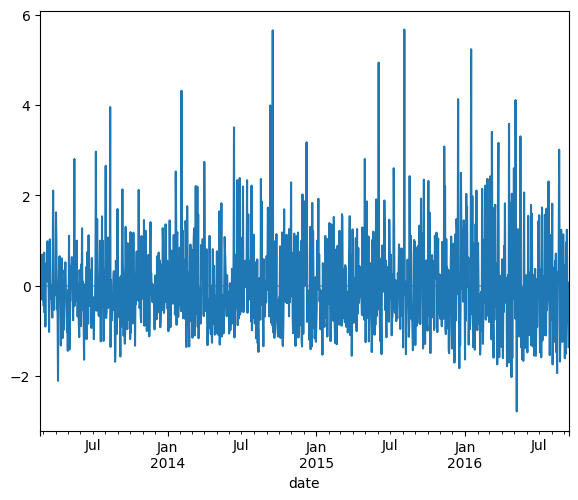

In [61]:
results.plot_diagnostics(figsize = (15, 12), lags = 3);

In [62]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = results.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()

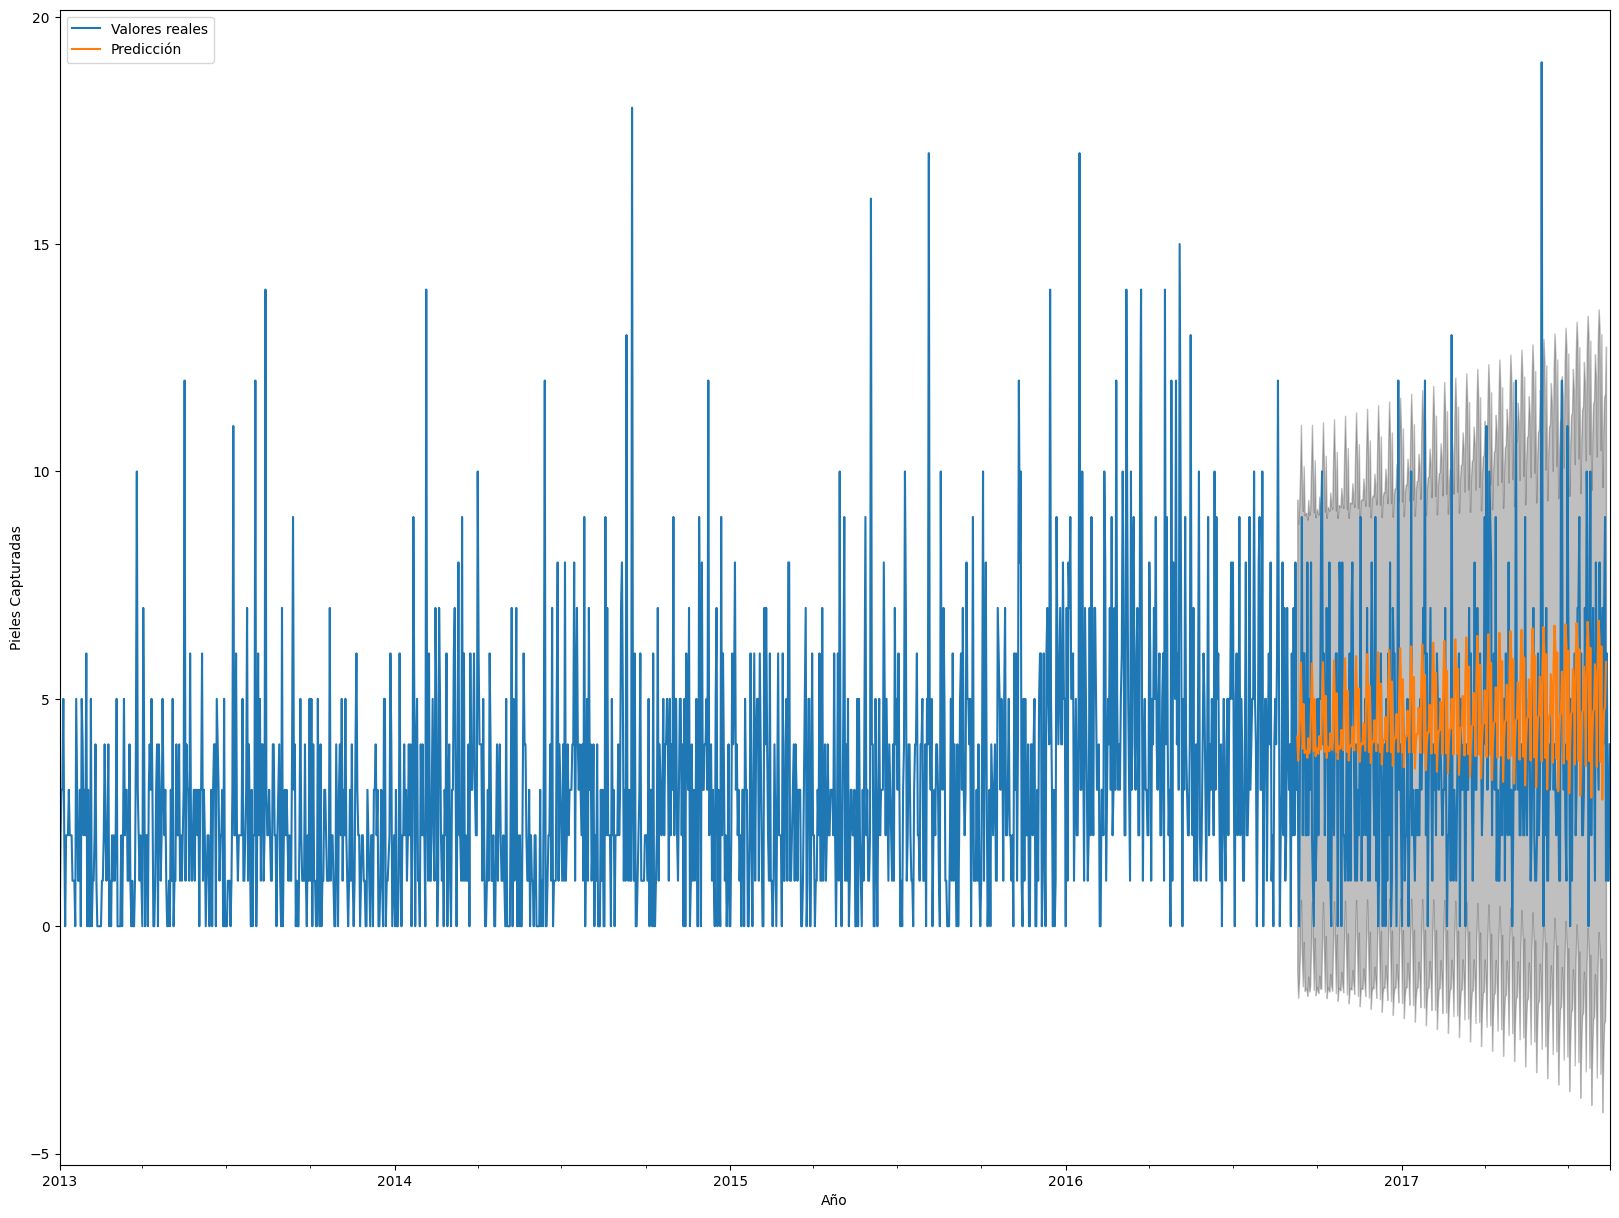

In [63]:
ax = y.loc(axis=1)[(STORE_NBR, FAMILY)].plot(label = 'Valores reales', figsize = (20, 15))

pred_uc.predicted_mean.plot(ax = ax, label = 'Predicción')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Año')
ax.set_ylabel('Pieles Capturadas')

plt.legend()
plt.show()

In [64]:
y_pred = pred_ci.iloc[:, 0]

In [66]:
y_pred = y_pred.apply(lambda x: 0 if x < 0 else x)

In [67]:
root_mean_squared_log_error(y_test, y_pred)

1.5450555082895443

Machine Learning

In [68]:
def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)


def make_multistep_target(ts, steps, reverse=False):
    shifts = reversed(range(steps)) if reverse else range(steps)
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in shifts}, axis=1)

In [69]:
train

,store_nbr,family,sales,onpromotion,dcoilwtico,type_B,type_C,type_D,type_E,cluster_2,...,Terremoto Manabi+5,Terremoto Manabi+6,Terremoto Manabi+7,Terremoto Manabi+8,Terremoto Manabi+9,Traslado Batalla de Pichincha,Traslado Independencia de Guayaquil,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0,0.00,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BABY CARE,0.000,0,0.00,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BEAUTY,0.000,0,0.00,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BEVERAGES,0.000,0,0.00,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BOOKS,0.000,0,0.00,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0,47.57,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-15,9,PREPARED FOODS,154.553,1,47.57,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-15,9,PRODUCE,2419.729,148,47.57,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
data_train = train.copy()
data_train = data_train.reset_index()
data_train["date"] = pd.to_datetime(data_train["date"])
data_train = data_train.pivot_table(index="date", columns=["store_nbr", "family"], values=["sales", "onpromotion"], fill_value=0)

In [76]:
data_train.head(10)

onpromotion                                                \
store_nbr           1                                                  
family      AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                   
2013-01-01         0.0       0.0    0.0       0.0   0.0          0.0   
2013-01-02         0.0       0.0    0.0       0.0   0.0          0.0   
2013-01-03         0.0       0.0    0.0       0.0   0.0          0.0   
2013-01-04         0.0       0.0    0.0       0.0   0.0          0.0   
2013-01-05         0.0       0.0    0.0       0.0   0.0          0.0   
2013-01-06         0.0       0.0    0.0       0.0   0.0          0.0   
2013-01-07         0.0       0.0    0.0       0.0   0.0          0.0   
2013-01-08         0.0       0.0    0.0       0.0   0.0          0.0   
2013-01-09         0.0       0.0    0.0       0.0   0.0          0.0   
2013-01-10         0.0       0.0    0.0       0.0   0.0          0.0   

                                            ...     sales             \
store_nbr                                   ...        54              
family     CELEBRATION CLEANING DAIRY DELI  ... MAGAZINES      MEATS   
date                                        ...                        
2013-01-01         0.0      0.0   0.0  0.0  ...       0.0   0.000000   
2013-01-02         0.0      0.0   0.0  0.0  ...       0.0  73.771000   
2013-01-03         0.0      0.0   0.0  0.0  ...       0.0  50.257000   
2013-01-04         0.0      0.0   0.0  0.0  ...       0.0  40.223000   
2013-01-05         0.0      0.0   0.0  0.0  ...       0.0  43.431000   
2013-01-06         0.0      0.0   0.0  0.0  ...       0.0  66.222000   
2013-01-07         0.0      0.0   0.0  0.0  ...       0.0  41.093998   
2013-01-08         0.0      0.0   0.0  0.0  ...       0.0  37.015000   
2013-01-09         0.0      0.0   0.0  0.0  ...       0.0  32.940000   
2013-01-10         0.0      0.0   0.0  0.0  ...       0.0  35.335000   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   
2013-01-06         300.0          0.0                     0.0  43.074   
2013-01-07         180.0          0.0                     0.0   5.907   
2013-01-08         140.0          0.0                     0.0  22.449   
2013-01-09         110.0          0.0                     0.0  27.335   
2013-01-10          99.0          0.0                     0.0  10.485   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  
2013-01-06           58.0     0.0                        0.0     0.0  
2013-01-07           15.0     0.0                        0.0     3.0  
2013-01-08           45.0     0.0                        0.0     1.0  
2013-01-09           48.0     0.0                        0.0     1.0  
2013-01-10           36.0     0.0              

In [77]:
y = data_train.loc[:, 'sales']

X = make_lags(y, lags=4).dropna()

y = make_multistep_target(y, steps=16).dropna()    # Number of steps to forecast

y, X = y.align(X, join='inner', axis=0)

In [78]:
y.head()

y_step_1                                                \
store_nbr          1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   
2013-01-06        2.0       0.0    0.0     407.0   0.0      147.182   
2013-01-07        0.0       0.0    1.0    1158.0   0.0      309.676   
2013-01-08        2.0       0.0    3.0    1029.0   0.0      321.851   
2013-01-09        2.0       0.0    1.0    1186.0   0.0      298.582   

                                                 ... y_step_16          \
store_nbr                                        ...        54           
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  90.857   
2013-01-06         0.0    257.0  212.0   60.135  ...       0.0  53.128   
2013-01-07         0.0    829.0  400.0  113.235  ...       0.0  34.175   
2013-01-08         0.0    827.0  384.0  130.085  ...       0.0  30.995   
2013-01-09         0.0    906.0  530.0  147.149  ...       0.0  31.758   

                                                                          \
store_nbr                                                                  
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS    POULTRY   
date                                                                       
2013-01-05         251.0          0.0                     0.0  34.359000   
2013-01-06         153.0          0.0                     0.0  19.605000   
2013-01-07         125.0          0.0                     0.0  30.341000   
2013-01-08          95.0          0.0                     0.0  25.511002   
2013-01-09          70.0          0.0                     0.0  37.812000   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-05           58.0     0.0                        0.0     7.0  
2013-01-06           39.0     0.0                        0.0     0.0  
2013-01-07           36.0     0.0                        0.0     2.0  
2013-01-08           31.0     0.0                        0.0     0.0  
2013-01-09           42.0     0.0                        0.0     4.0  

[5 rows x 28512 columns]

In [79]:
X.head()

y_lag_1                                                \
store_nbr          1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-05        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-06        5.0       0.0    3.0    1160.0   0.0      301.057   
2013-01-07        2.0       0.0    0.0     407.0   0.0      147.182   
2013-01-08        0.0       0.0    1.0    1158.0   0.0      309.676   
2013-01-09        2.0       0.0    3.0    1029.0   0.0      321.851   

                                                 ...   y_lag_4          \
store_nbr                                        ...        54           
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-05         0.0    827.0  460.0  131.411  ...       0.0   0.000   
2013-01-06         0.0    811.0  464.0  118.613  ...       0.0  73.771   
2013-01-07         0.0    257.0  212.0   60.135  ...       0.0  50.257   
2013-01-08         0.0    829.0  400.0  113.235  ...       0.0  40.223   
2013-01-09         0.0    827.0  384.0  130.085  ...       0.0  43.431   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-05           0.0          0.0                     0.0   0.000   
2013-01-06         228.0          0.0                     0.0  15.514   
2013-01-07         156.0          0.0                     0.0   4.313   
2013-01-08         146.0          0.0                     0.0  26.743   
2013-01-09         205.0          0.0                     0.0  31.118   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-05            0.0     0.0                        0.0     0.0  
2013-01-06           61.0     0.0                        0.0     3.0  
2013-01-07            1.0     0.0                        0.0     2.0  
2013-01-08           38.0     0.0                        0.0     2.0  
2013-01-09           32.0     0.0                        0.0     1.0  

[5 rows x 7128 columns]

In [81]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

C:\Users\ivan.trujillo_blueta\AppData\Local\Temp\ipykernel_22552\1924193735.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X = (X
C:\Users\ivan.trujillo_blueta\AppData\Local\Temp\ipykernel_22552\1924193735.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y = y.stack('family')  # wide to long


In [82]:
y.head()

y_step_1                                                 \
store_nbr                   1       2       3       4      5       6       7    
date       family                                                               
2013-01-05 AUTOMOTIVE      5.0     5.0    12.0     9.0    4.0     4.0     3.0   
           BABY CARE       0.0     0.0     0.0     0.0    0.0     0.0     0.0   
           BEAUTY          3.0     9.0     8.0     4.0    5.0     4.0     4.0   
           BEVERAGES    1160.0  1581.0  4886.0  1551.0  912.0  1898.0  1828.0   
           BOOKS           0.0     0.0     0.0     0.0    0.0     0.0     0.0   

                                              ... y_step_16                  \
store_nbr                  8       9      10  ...        45      46      47   
date       family                             ...                             
2013-01-05 AUTOMOTIVE    10.0    27.0    0.0  ...      19.0    16.0    18.0   
           BABY CARE      0.0     0.0    0.0  ...       0.0     0.0     0.0   
           BEAUTY         8.0     9.0    3.0  ...      11.0    18.0    16.0   
           BEVERAGES   2968.0  1415.0  624.0  ...    6284.0  4305.0  5569.0   
           BOOKS          0.0     0.0    0.0  ...       0.0     0.0     0.0   

                                                                        
store_nbr                  48      49      50      51   52   53     54  
date       family                                                       
2013-01-05 AUTOMOTIVE    20.0     2.0    18.0    12.0  0.0  0.0    9.0  
           BABY CARE      0.0     0.0     0.0     0.0  0.0  0.0    0.0  
           BEAUTY        12.0     8.0     9.0     2.0  0.0  0.0    0.0  
           BEVERAGES   3209.0  3728.0  2498.0  2335.0  0.0  0.0  472.0  
           BOOKS          0.0     0.0     0.0     0.0  0.0  0.0    0.0  

[5 rows x 864 columns]

In [86]:
model = RegressorChain(XGBRegressor())

OPTUNA!?

In [87]:
model.fit(X, y)

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...))

In [88]:
y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

In [89]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [96]:
plot_params = dict(
    color="0.25",
    style=".-",
    markeredgecolor="0.15",
    markerfacecolor="0.15",
    legend=False,
)

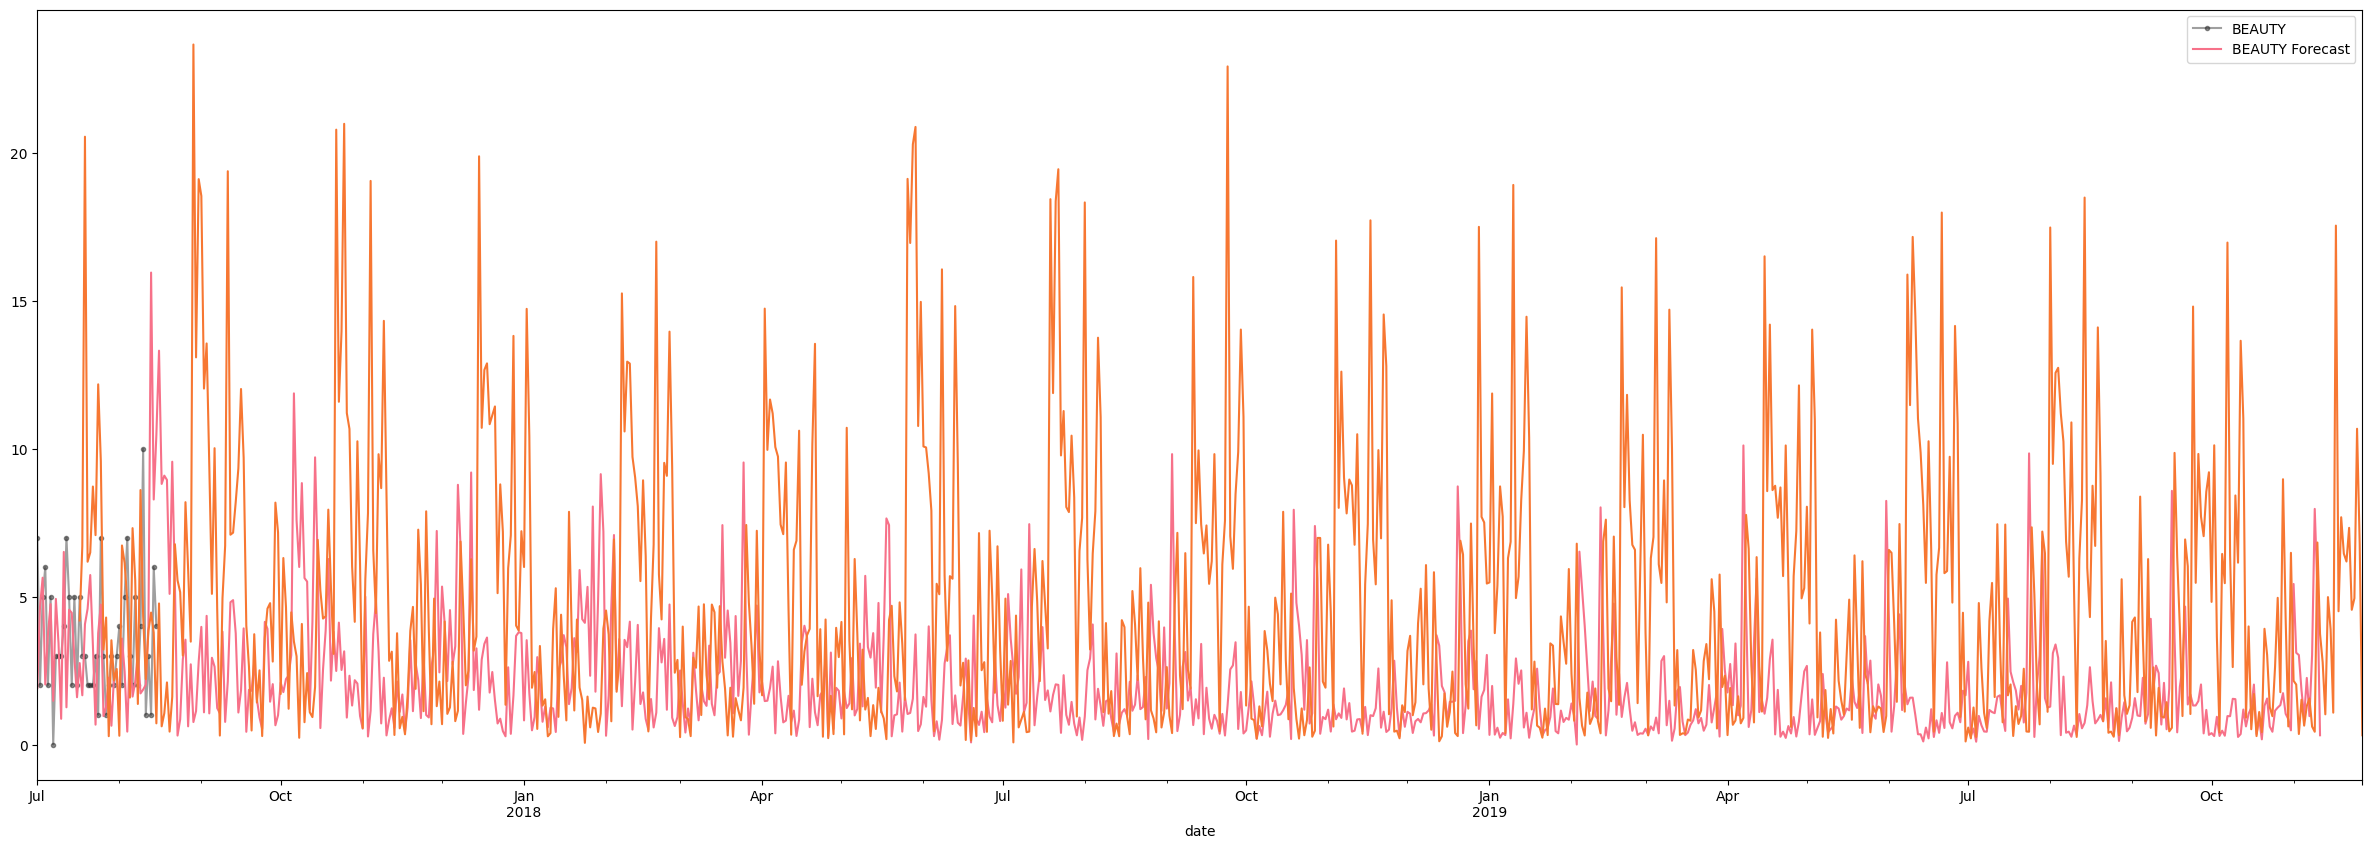

In [102]:
STORE_NBR = 1
FAMILY = 'BEAUTY'
START = '2017-07-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = data_train.loc[START:, 'sales'].loc[:, (STORE_NBR, FAMILY)]

fig, ax = plt.subplots(1, 1, figsize=(30, 10))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

In [112]:
y_pred

y_step_1                            \
store_nbr                                       1            2            3    
date       family                                                              
2013-01-05 AUTOMOTIVE                     1.469431     1.800420     1.526228   
           BABY CARE                      0.771245     0.437798     1.023637   
           BEAUTY                         1.496743     1.800420     3.005169   
           BEVERAGES                   1105.241211  1537.598877  4098.963379   
           BOOKS                          0.771245     0.437798     1.023637   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      313.708374   426.740509  1091.173462   
           PREPARED FOODS                78.258171   116.167114   298.855530   
           PRODUCE                     2573.792480  2227.014404  8043.478027   
           SCHOOL AND OFFICE SUPPLIES     2.932169     0.000000     8.230449   
           SEAFOOD                       19.522570    29.393074    89.616386   

                                                                              \
store_nbr                                       4            5            6    
date       family                                                              
2013-01-05 AUTOMOTIVE                     2.094466     4.166542     1.939682   
           BABY CARE                      0.344466     0.644559     0.431140   
           BEAUTY                         1.087092     0.644559     0.815869   
           BEVERAGES                   1228.906128   895.499512  1598.315674   
           BOOKS                          0.344466     0.644559     0.431140   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      406.070709   212.181747   579.632385   
           PREPARED FOODS                65.546265    72.565971   113.562706   
           PRODUCE                     2090.676270  1551.456787  2518.410400   
           SCHOOL AND OFFICE SUPPLIES    10.192996     0.971929     2.935545   
           SEAFOOD                       25.475506     9.198009    36.509399   

                                                                              \
store_nbr                                       7            8            9    
date       family                                                              
2013-01-05 AUTOMOTIVE                     0.608348     5.373636     6.261396   
           BABY CARE                      0.608348     0.553293     0.965054   
           BEAUTY                         1.018511     2.658076     0.965054   
           BEVERAGES                   1767.786377  2234.328125  1468.309326   
           BOOKS                          0.608348     0.553293     0.965054   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      697.845032   582.146606   363.725494   
           PREPARED FOODS               147.170563   173.727036   105.111519   
           PRODUCE                     5475.890625  4383.557617  1423.105469   
           SCHOOL AND OFFICE SUPPLIES     4.414303     2.541635    44.018814   
           SEAFOOD                       56.227859    46.837227    16.850899   

                                                   ...    y_step_16  \
store_nbr                                      10  ...           45   
date       family                                  ...                
2013-01-05 AUTOMOTIVE                    1.160980  ...     1.086723   
           BABY CARE                     0.246086  ...     1.086723   
           BEAUTY                        2.012348  ...     3.103659   
           BEVERAGES                   619.153870  ...  3864.840576   
           BOOKS                         0.246086  ...     1.086723   
...                                           ...  ...          ...   
2017-07-31 POULTRY                     1

In [117]:
root_mean_squared_log_error(y, y_pred)

0.8552271648138601

In [115]:
test_id = test["id"]
test = test.drop("id", axis=1)
test

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0
...,...,...,...,...
28507,2017-08-31,9,POULTRY,1
28508,2017-08-31,9,PREPARED FOODS,0
28509,2017-08-31,9,PRODUCE,1
28510,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [118]:
X_test = test.copy()
X_test = X_test.reset_index()
X_test["date"] = pd.to_datetime(X_test["date"])
X_test = X_test.pivot_table(index="date", columns=["store_nbr", "family"], values=["onpromotion"], fill_value=0)

In [122]:
y_pred[-1:]

y_step_1                                             \
store_nbr                 1          2          3          4         5    
date       family                                                         
2017-07-31 SEAFOOD  19.52257  29.393074  89.616386  25.475506  9.198009   

                                                                          ...  \
store_nbr                  6          7          8          9         10  ...   
date       family                                                         ...   
2017-07-31 SEAFOOD  36.509399  56.227859  46.837227  16.850899  2.829985  ...   

                    y_step_16                                             \
store_nbr                  45         46         47         48        49   
date       family                                                          
2017-07-31 SEAFOOD  69.080574  39.643387  63.930397  26.186871  73.86834   

                                                                         
store_nbr                  50         51         52        53        54  
date       family                                                        
2017-07-31 SEAFOOD  30.464884  55.883377  11.505774  6.760689  0.676348  

[1 rows x 864 columns]

LSTM

In [ ]:
# LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    layers.Dense(16),
])

model.compile(optimizer='adam', loss='mse')

X = X.values.reshape(X.shape[0], 1, X.shape[1])
y = y.values

model.fit(X, y, epochs=10, batch_size=32)

y_pred = model.predict(X)

y_pred = pd.DataFrame(
    y_pred,
    index=y.index,
    columns=y.columns,
).clip(0.0)

y_pred
